In [1]:
import neural_process as nep
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

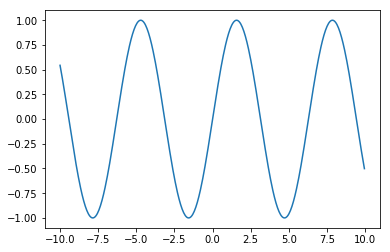

In [2]:
# for each example: 1 x and 1 y, meaning that they would be tensors with tensor.Size([N_examples, 1])
x_all = np.arange(-10, 10, 0.05).reshape(-1, 1).astype(np.float32)
y_all = np.sin(x_all)

plt.plot(x_all, y_all)
plt.show()

In [24]:
# Helpers
def randsplit_totensor(x, y, n_context):
    index = np.arange(x.shape[0])
    mask = np.random.choice(index, size=n_context, replace=False)
    x_context = torch.from_numpy(x[mask])
    y_context = torch.from_numpy(y[mask])
    x_target = torch.from_numpy(np.delete(x, mask, axis=0))
    y_target = torch.from_numpy(np.delete(y, mask, axis=0))
    return x_context, y_context, x_target, y_target


def KL(mean_q, logvar_q, mean_p, logvar_p):
    var_p = torch.exp(logvar_p)
    kl_div = (torch.exp(logvar_q) + (mean_q - mean_p) ** 2) / var_p \
             - 1.0 \
             + logvar_p - logvar_q
    kl_div = 0.5 * kl_div.sum()
    return kl_div



def log_likelihood(mu, std, target):
    norm = torch.distributions.Normal(mu, std)
    return norm.log_prob(target).sum(dim=0).mean()
# def log_likelihood(mean, logvar, target):
#     std = torch.exp(0.5 * logvar)
#     norm = torch.distributions.Normal(mean, std)
#     log_lik = norm.log_prob(target).sum(dim=0).mean()
#     return log_lik

-----

In [4]:
n_context = 30
x_c, y_c, x_t, y_t = randsplit_totensor(x_all, y_all, n_context)

In [5]:
# Parameters
r_dim = 8
z_dim = 10
h_specs = [(5, torch.nn.ReLU()), (10, torch.nn.ReLU()), (5, torch.nn.ReLU()), (r_dim, None)]
g_specs = [(5, torch.nn.ReLU()), (10, torch.nn.ReLU()), (x_t.shape[1], None)]

h_input_dim = x_c.shape[1] + y_c.shape[1]
g_input_dim = x_t.shape[1] + z_dim

h = nep.Encoder(h_input_dim, h_specs)
r_to_z = nep.Zparams(r_dim, z_dim)
g = nep.Decoder(g_input_dim, g_specs)

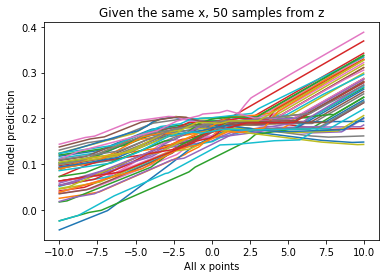

In [6]:
# generate examples using the entire dataset
x_all_tensor = torch.from_numpy(x_all)

# generate 50 samples from z
z = torch.from_numpy(np.random.normal(size=(50, z_dim)).astype(np.float32))

# reshape to plot
z_s = z.unsqueeze(-1).expand(z.shape[0], z.shape[1], x_all_tensor.shape[0]).transpose(1,2)
x_s = x_all_tensor.unsqueeze(0).expand(z.shape[0], x_all_tensor.shape[0], x_all_tensor.shape[1])

# create 50 matrices to be inputted in the decoder
xz = torch.cat([x_s, z_s], dim=2)

# plt.plot(x_all_tensor.data.numpy(), np.sin(x_all_tensor.data.numpy()))
for i in range(xz.shape[0]):
    y_hat_mean, _ = g(xz[i])
    plt.plot(x_all_tensor.data.numpy(), y_hat_mean.data.numpy())
plt.title('Given the same x, 50 samples from z')
plt.xlabel('All x points')
plt.ylabel('model prediction')
plt.show()

-----

In [68]:
optimizer = torch.optim.Adam(list(g.parameters()) + list(h.parameters()) + list(r_to_z.parameters()), 0.001)
epochs = 1000

In [72]:
for epoch in range(epochs): 
    optimizer.zero_grad()
    
    n_context = np.random.choice(range(x_all.shape[0]))
    x_c, y_c, x_t, y_t = randsplit_totensor(x_all, y_all, n_context)
    x_all_tensor = torch.cat([x_c, x_t], dim=0)
    y_all_tensor = torch.cat([y_c, y_t], dim=0)

    # Get latent variables for all data, and for context only
    # forward pass using only context point to estimate z_mean, z_logvar
    xy_c = torch.cat([x_c, y_c], dim=1)
    r_c = nep.aggregate(h(xy_c))
    z_mean_c, z_logvar_c = r_to_z(r_c)
    
    # forward pass using all data to estimate z_mean, z_logvar
    xy_all = torch.cat([x_all_tensor, y_all_tensor], dim=1)
    r_all = nep.aggregate(h(xy_all))
    z_mean_all, z_logvar_all = r_to_z(r_all)

    #Sample a batch of zs using reparam trick.
    z_sample_all = nep.sample_z(z_mean_all, z_logvar_all, 1)

    # Get the predictive distribution of y*
    xt_zall = torch.cat([x_t, z_sample_all.expand(x_t.shape[0], z_sample_all.shape[1])], dim=1)
    mean, std = g(xt_zall)
    
    #Compute loss and backprop
    loss = -log_likelihood(mean, std, y_t) + KL(z_mean_all, z_logvar_all, z_mean_c, z_logvar_c)
    loss.backward()
    optimizer.step()
#     print(loss)

#     if epoch % 100 == 0:
#         z = nep.sample_z(z_mean_all, z_logvar_all, 50) 
#         x = x_all_tensor.unsqueeze(0).expand(z.shape[0], x_all_tensor.shape[0], x_all_tensor.shape[1])
#         xz = torch.cat([x,z], dim=2)
#         for i in range(xz.shape[0]):
#             y_hat_mean, _ = g(xz[i])
#             plt.plot(x_all, y_hat_mean.data.numpy())
#         plt.title('Given the same x, 50 samples from z')
#         plt.xlabel('All x points')
#         plt.ylabel('model prediction')
#         plt.show()

tensor(1757112., grad_fn=<ThAddBackward>)
tensor(83580., grad_fn=<ThAddBackward>)
tensor(1164693.2500, grad_fn=<ThAddBackward>)
tensor(1453442.2500, grad_fn=<ThAddBackward>)
tensor(1565353.7500, grad_fn=<ThAddBackward>)
tensor(1115511.3750, grad_fn=<ThAddBackward>)
tensor(455348.1250, grad_fn=<ThAddBackward>)
tensor(1691639.5000, grad_fn=<ThAddBackward>)
tensor(196679.6250, grad_fn=<ThAddBackward>)
tensor(317898.3125, grad_fn=<ThAddBackward>)
tensor(1626700.8750, grad_fn=<ThAddBackward>)
tensor(211815.3281, grad_fn=<ThAddBackward>)
tensor(2433844.7500, grad_fn=<ThAddBackward>)
tensor(2371589.2500, grad_fn=<ThAddBackward>)
tensor(124472.1406, grad_fn=<ThAddBackward>)
tensor(186720.4531, grad_fn=<ThAddBackward>)
tensor(1049394.7500, grad_fn=<ThAddBackward>)
tensor(3465430.7500, grad_fn=<ThAddBackward>)
tensor(974602.1250, grad_fn=<ThAddBackward>)
tensor(3514863.2500, grad_fn=<ThAddBackward>)
tensor(2139922., grad_fn=<ThAddBackward>)
tensor(43612.1680, grad_fn=<ThAddBackward>)
tensor(1088

RuntimeError: cannot unsqueeze empty tensor